## Supplementary Figure 5

Inspecting for plate position effects and how well spherize transformations improve.

Related to Figure 1.


In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "supplementary", "figureS5_platepositioneffects")
extensions <- c(".png", ".pdf")

In [3]:
# Load data
analysis_dir <- file.path("..", "1.Data-exploration", "Profiles_level4", "plate_position_effects", "results")
plate_file <- file.path(analysis_dir, "well_position_replicate_and_nonreplicate_median_correlations.tsv.gz")

plate_cols <- readr::cols(
  Metadata_Well = readr::col_character(),
  Metadata_broad_sample_replicate = readr::col_logical(),
  median_cor = readr::col_double(),
  sample_counts = readr::col_double(),
  assay = readr::col_character(),
  normalization = readr::col_character()
)

plate_df <- readr::read_tsv(plate_file, col_types = plate_cols) %>%
    dplyr::mutate(
        col = substring(Metadata_Well, 1, 1),
        row = substring(Metadata_Well, 2)
    )

plate_df$col <- factor(plate_df$col, levels = rev(LETTERS[0:16]))

print(dim(plate_df))
head(plate_df, 3)

[1] 3420    9


Metadata_Well,Metadata_broad_sample_replicate,mean_cor,median_cor,sample_counts,assay,normalization,col,row
<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>
A07,FALSE,0.01258404,0.008729822,5358,Cell Painting,spherized,A,07
A07,TRUE,0.19107974,0.091624401,207,Cell Painting,spherized,A,07
A08,FALSE,0.00768390,0.005519570,5358,Cell Painting,spherized,A,08


In [4]:
table(plate_df$normalization)


nonspherized    spherized 
        1368         2052 

In [5]:
append_replicate <- function(string) paste("Profile replicates:", string)
append_norm <- function(string) paste("Normalization:", stringr::str_to_title(string))


all_ggs <- list()
for (assay in unique(plate_df$assay)) {
    all_ggs[[assay]] <- list()
    for (replicate_status in unique(plate_df$Metadata_broad_sample_replicate)) {
        replicate_status_string <- paste0("replicate_status_", replicate_status)
        all_ggs[[assay]][[replicate_status_string]] <- list()
        for (normalization in unique(plate_df$normalization)) {
            plate_subset_df <- plate_df %>%
                dplyr::filter(
                    assay == !!assay,
                    Metadata_broad_sample_replicate == !!replicate_status,
                    normalization == !!normalization
                )
            
            plate_subset_gg <- (
                ggplot(plate_subset_df, aes(x = row, y = col))
                + geom_point(aes(fill = mean_cor), size = 3, pch = 22, stroke = 0.2)
                 + facet_grid(
                    "~normalization",
                    labeller = labeller(
                        Metadata_broad_sample_replicate = as_labeller(append_replicate),
                        normalization = as_labeller(append_norm)
                    )
                )
                + figure_theme
                + coord_fixed()
                + xlab("Plate row")
                + ylab("Plate column")
                + ggtitle(assay)
                + scale_fill_gradient(name = "Same-well\nmean\npairwise\nPearson\ncorrelation", low = "white", high = "red", na.value = "grey")
                + theme(
                    plot.margin = unit(c(t = 0, r = 0.25, b = 0, l = 0.25), "cm"),
                    axis.text = element_text(size = 6),
                    panel.grid.major = element_blank(),
                    panel.grid.minor = element_blank(),
                    panel.background = element_rect(fill = "grey")
                )
                
            )
            
            all_ggs[[assay]][[replicate_status_string]][[normalization]] <- plate_subset_gg
        }
    }
}

## Compile figure

- Columns: spherized (left) vs. non-spherized (right)
- Rows: Cell Painting (top) vs. L1000 (bottom)

In [6]:
top_left_gg <- all_ggs[["Cell Painting"]][["replicate_status_FALSE"]][["spherized"]]
top_right_gg <- all_ggs[["Cell Painting"]][["replicate_status_FALSE"]][["nonspherized"]]
bottom_left_gg <- all_ggs[["L1000"]][["replicate_status_FALSE"]][["spherized"]]
bottom_right_gg <- all_ggs[["L1000"]][["replicate_status_FALSE"]][["nonspherized"]]

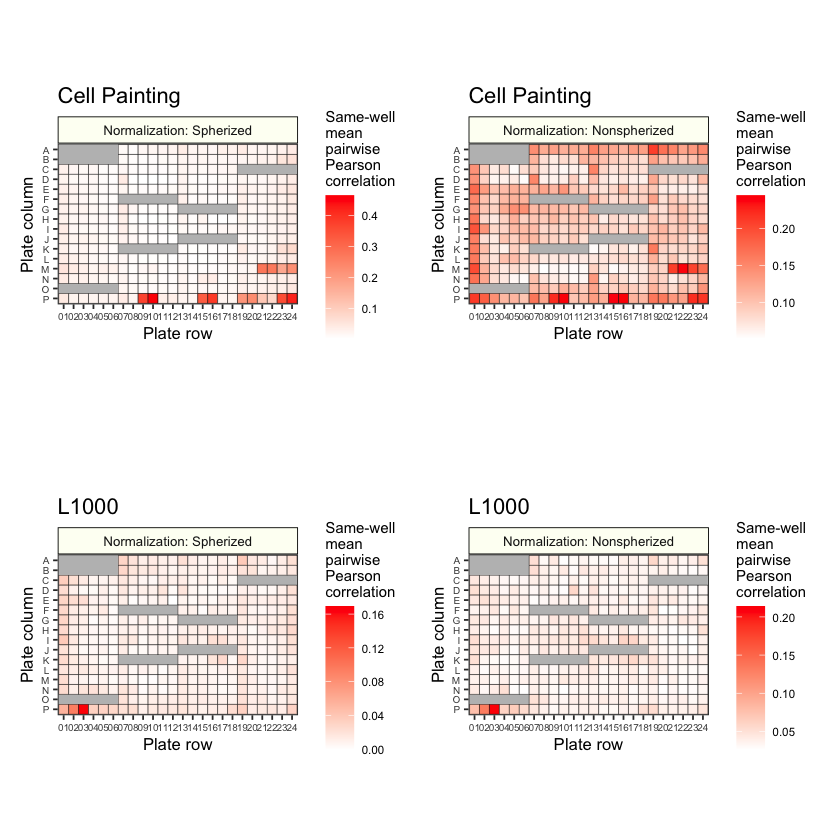

In [7]:
plate_non_replicate_gg <- (
    (
        top_left_gg | top_right_gg 
    ) / (
        bottom_left_gg | bottom_right_gg
    )
)

for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    ggplot2::ggsave(output_file, plate_non_replicate_gg, width = 8.6, height = 5, dpi = 500)
}

plate_non_replicate_gg